# Model Inversion & Stealing

In [55]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, or `cifar` while the split depth is between 1 and 6 for MNIST datasets, and 1 and 8 for the CIFAR dataset.

In [56]:
split_layer = 1

In [12]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [13]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.2995339035987854 Acc: 97.74477447744775
Epoch: 1 Loss: 0.07789472490549088 Acc: 97.74104683195593
Epoch: 2 Loss: 0.054312996566295624 Acc: 98.80434782608695
Epoch: 3 Loss: 0.041438713669776917 Acc: 98.56670341786108
Epoch: 4 Loss: 0.03416971489787102 Acc: 98.69494290375204
Epoch: 5 Loss: 0.0288735032081604 Acc: 98.91126837234621
Epoch: 6 Loss: 0.023831412196159363 Acc: 99.28057553956835
Epoch: 7 Loss: 0.021889515221118927 Acc: 99.38922820655192
Epoch: 8 Loss: 0.01869536004960537 Acc: 99.11797133406836
Epoch: 9 Loss: 0.016306912526488304 Acc: 98.57064321055525


We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

In [57]:
def display_imagelist(images, height, width, count=1):
    fig, ax = plt.subplots(count, len(images)) #1
    if count == 1:
        for index, image in enumerate(images):
            ax[index].axis('off')
            ax[index].imshow(image.cpu().detach().reshape(height, width))
    else:
        for id, nested in enumerate(images):
            for index, image in enumerate(nested):
                ax[index, id].axis('off')
                ax[index, id].imshow(image.cpu().detach().reshape(height, width))
    plt.show()

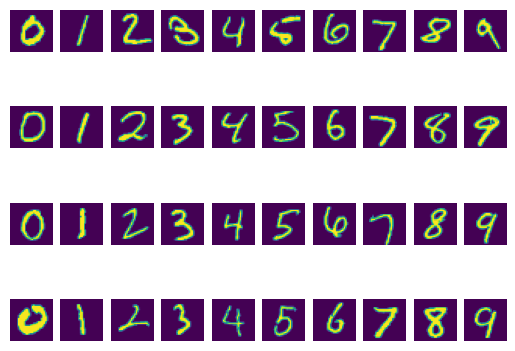

In [58]:
COUNT = 4

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28, count=COUNT)

We now launch the attack, iterating over the examples from the previous cell.

You can change the `main_iters`, `input_iters`, and `model_iters` variables to observe how the attack performs under different configurations.

In [62]:
for id,target in enumerate(targetloader):
    print(id, target)
    break

0 [tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.000

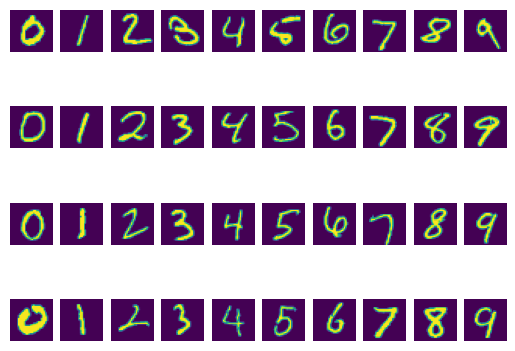

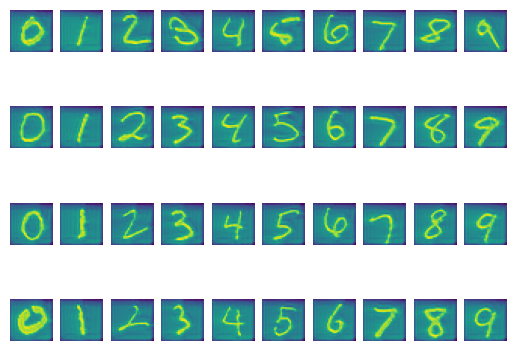

In [142]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

WITHOUT TOTAL VARIATION

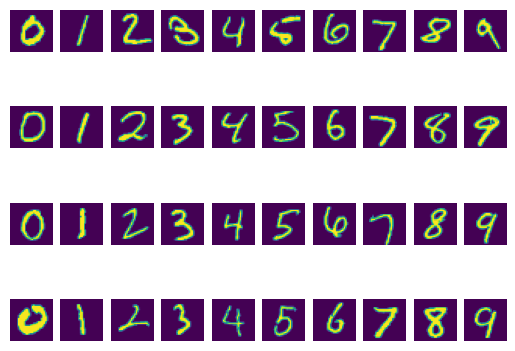

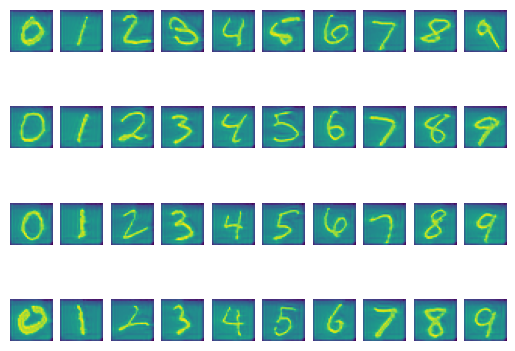

In [143]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_tv=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_tv=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

WITHOUT L2 W TOTAL VARIANTION

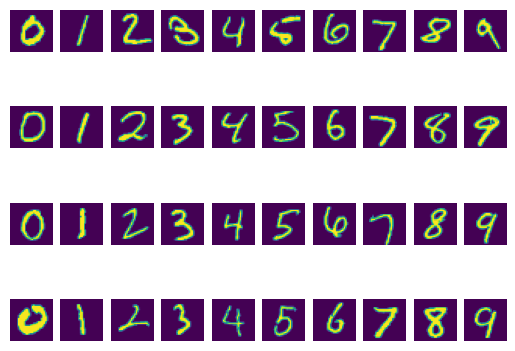

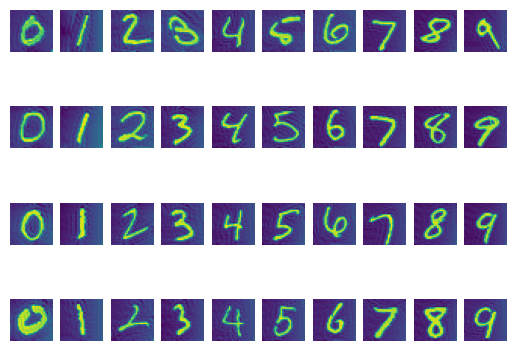

In [144]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

WITHOUT EVERYTHING

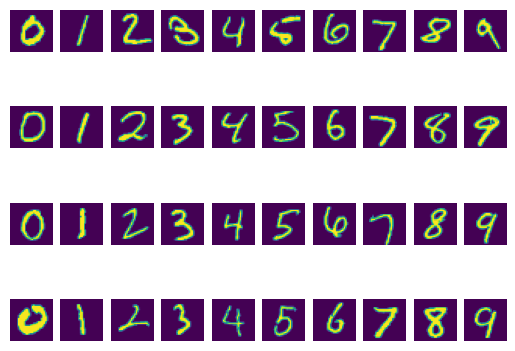

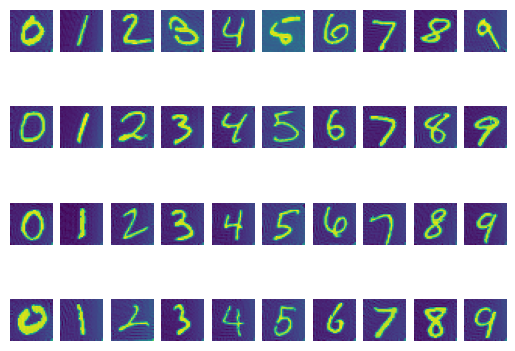

In [145]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0, lambda_tv=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0, lambda_tv=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)